# Tarea 1: Reconocimiento basico
Reconocimiento de Patrones (IIC2233)

Primer semestre 2024

Pedro Pablo Zavala Tejos

# 0. Initial Setup

In [108]:
import numpy as np
import matplotlib.pyplot as plt # Libreria para realizar gráficos
import seaborn as sns
import cv2 # Libreria para procesamiento morfológico de imagenes

# 1. Image Loading


💬 Cargamos los datos desde dropbox

In [109]:
# !wget https://www.dropbox.com/scl/fi/5n62okx5uosbdtvwyzova/kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb&dl=0 # Cargamos los datos

In [110]:
# !mv kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb kchipun.zip

In [111]:
# !unzip -qq kchipun.zip # descomprimimos el archivo

💬 Definimos las siguientes funciones para cargar las imagenes. 

In [112]:

def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un 
    identificador de imagen num_img
    """
    BASE_URL = 'kchipun/img_'
    DIGITS_CLASS = 2
    DIGITS_IMG = 4
    path = f'{BASE_URL}{num2fixstr(num_class, DIGITS_CLASS)}{sep}{num2fixstr(num_img, DIGITS_IMG)}.png'
    return path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen utilizando la libreria cv2
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = cv2.imread(path, 0)
    return img

def plot_image(num_class: int, num_img: int, echo='off') -> str:
    """
    Ilustra la imagen con matplotlib
    """
    img = imageload(num_class, num_img, echo='on')
    plt.imshow(img, cmap='gray')

💬 Para hacer una prueba, cargamos una imagen para cada clase

loading image kchipun/img_01_0001.png ...


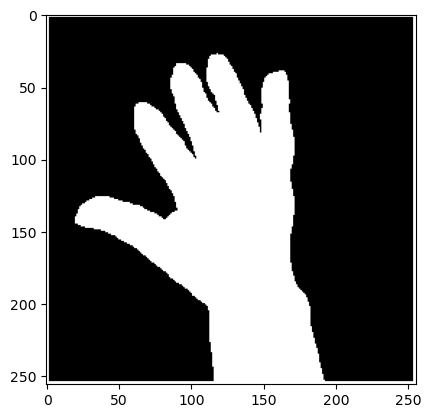

In [113]:
# Imagen binaria clase papel
plot_image(1, 1)

loading image kchipun/img_02_0001.png ...


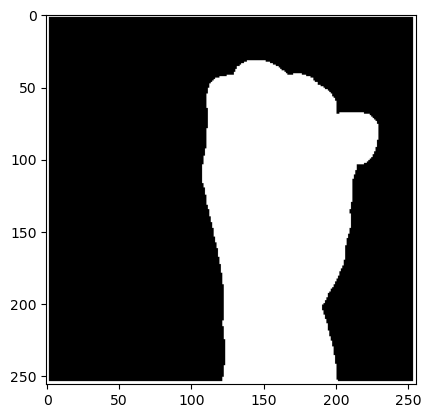

In [114]:
# Imagen binaria clase piedra
plot_image(2, 1)

loading image kchipun/img_03_0001.png ...


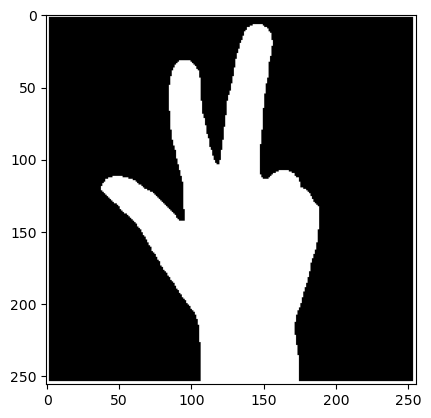

In [115]:
# Imagen binaria clase tijera
plot_image(3, 1)

# 2. Feature Extraction

## Funciones de operaciones morfologicas

💬 Las siguientes funciones permiten realizar operaciones morfologicas de una imagen. Estas
las utilizaremos para poder manipular la imagen al momento de obtener caracteristicas.


In [116]:
def erode(img):
    """
    Retorna la imagen con la operacion morfologica de erosión
    """
    return cv2.erode(img, np.ones((5,5), np.uint8), iterations=3)

def close(img):
    """
    Retorna la imagen sin hoyos pequeños de la figura
    """
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

def dilate(img):
    """
    Retorna una imagen con una dilatación de la figura, aumentando sus bordes externos
    """
    return cv2.dilate(img, kernel=np.ones((3,3), np.uint8), iterations = 3)

def border(img):
    """
    Retorna el borde de la figura de la imagen. El ancho del borde corresponde a 1 pixel. 
    """
    kernel = np.ones((2,2), np.uint8)
    img = dilate(img)
    border_img = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    return border_img

def delete_frame(img):
    """
    Las imagenes presentan un marco blanco que alteraba la obtencion de ciertas caracteristicas, 
    como los puntos mas lejanos o mas cercanos hacia el centro de masa. Por lo tanto, esta funcion 
    permite eliminar el marco blanco de aproximadamente 1 a 3 pixeles de la imagen.
    """
    return dilate(erode(img))

def rotate_and_flip(img):
    """
    Funcion que permite rotar a 90 grados positivamente y realizar una reflexion de la imagen con 
    respecto al eje x. 
    """
    rotate_img = np.rot90(dilate(erode(img)), k=1)
    flip_img = np.flip(rotate_img, axis=0)
    return flip_img


## Funciones _helpers_ para obtener caracteristicas
💬 Las siguientes funciones permiten obtener datos especificos de la figura. Estas funciones son 
utilizadas de ayuda en las funciones (que vienen despues de esta seccion de codigo) 
que permiten obtener caracteristicas de la figura. 


In [117]:
def get_region(img):
    """
    Retorna la region blanca de la imagen binaria (solamente pixeles con valores igual a 1)
    """
    return img == 255

def get_height_and_width(img):
    """
    Retorna el ancho y altura de la figura (region con pixeles igual a 1)
    """
    region = get_region(img)
    region_coords = np.argwhere(region)
    region_coords_i = region_coords[:,0] # Coordenadas eje i
    region_coords_j = region_coords[:,1] # Coordenadas eje j

    width = region_coords_i.max() - region_coords_i.min() + 1 # ancho de la figura
    height = region_coords_j.max() - region_coords_j.min() + 1 # altura de la figura 

    return height, width

def center_of_mass(img):
    """
    Retorna el punto de centro de masa de la figura. 
    """
    region = get_region(img) # region de la imagen
    region_coords = np.argwhere(region) # coordenadas que pertenecen a la region con valor distinto de 0

    region_coords_i = region_coords[:,0] # coordenadas i
    region_coords_j = region_coords[:,1] # coordenadas j

    coords_i_sum = np.sum(region_coords_i) # Suma de las coordenadas en el eje i
    coords_j_sum = np.sum(region_coords_j) # suma de las coordenadas en el eje j

    area = np.sum(region) # area de la figura

    coord_cm_i = coords_i_sum / area # coordenada del eje x del centro de masa
    coord_cm_j = coords_j_sum / area # coordenada del eje y del centro de masa

    return (coord_cm_i, coord_cm_j)

def euclidean_distance(point1, point2):
    """
    Encuentra la distancia euclidiana entre dos puntos en un espacio bi-dimensional. 
    """
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def extreme_points(img):
    """
    Encuentra los puntos mas extremos de la figura, tanto para
    el eje x e y. 

    """
    region_coords = np.argwhere(get_region(img)) # coordenadas dentro de la region de la figura

    region_axis_i = region_coords[:,0] # coordenadas eje i
    region_axis_j = region_coords[:,1] # coordenadas eje j 
    # punto minimo del eje i (punto mas alto)
    top = tuple(region_coords[region_axis_i.argmin()]) 
    # punto maximo del eje i (punto mas bajo)
    bottom = tuple(region_coords[region_axis_i.argmax()]) 
    # punto minimo del eje j (punto mas a la izquierda)
    left = tuple(region_coords[region_axis_j.argmin()])
    # punto maximo del j (punto mas a la derecha)
    right = tuple(region_coords[region_axis_j.argmax()])

    return top, bottom, left, right

def near_points(img):
    """
    Encuentra los puntos en el borde de la figura mas cercanos al centro de masa
    """
    most_near_points = []
    region_border = border(img) # borde de la imagen

    region_coords = np.argwhere(region_border) # coordenadas de la figura (pixeles con valores 1)
    center = center_of_mass(img) # centro de masa de la figura

    for point in region_coords:
        # para cada punto del borde, calculamos la distancia hasta el centro de masa
        distance = euclidean_distance(point, center)
        most_near_points.append((tuple(point), distance))
    # retornamos los puntos ordenados crecientemente segun la distancia 
    return sorted(most_near_points, key=lambda x: x[1])

def angle_between_fingers(left, center, top):
    """
    Funcion que retorna el angulo entre dos puntos. Utilizada principalmente para medir el angulo
    formado entre dos dedos. 
    l: left, c: center, t: top
    lc: left to center, ct: center to top
    Para obtener el angulo, utilizamos la formula de angulo entre dos vectores

    """
    lc_vector = np.array(left) - np.array(center) # vector desde el punto 'left' a 'center'
    ct_vector = np.array(top) - np.array(center) # vector desde el punto 'center' a 'top'

    norm_lc_vector = euclidean_distance(left, center) # norma del vector left-center
    norm_ct_vector = euclidean_distance(top, center) # norma del vector center-top

    dot_product = np.dot(lc_vector, ct_vector) # producto punto entre dos vectores
    norm_product = norm_lc_vector * norm_ct_vector # producto entre normas
    cos = dot_product / norm_product # coseno del angulo

    angle_rad = np.arccos(cos) # arcoseno del coseno (angulo) (medido en radianes)
    angle = np.degrees(angle_rad) # angulo (medido en grados)

    return angle



## Funciones de características
💬 Estas funciones nos permiten extraer directamente alguna caracteristica de la figura (en este
caso la mano). Por ejemplo, obtener el grado de redondez, el area de la figura, su simetría,
entre otros. 


In [118]:
def get_roundness(img):
    """
    Retorna el grado de redondez de la figura
    """
    region = get_region(img) # region que abarca la figura en la imagen
    region_border = border(img) # borde de la figura

    perimeter = get_region(region_border).sum() # perimetro de la figura
    area = np.sum(region) # area de la figura
    # redondez (roundness) de la figura 
    roundness = (4 * np.pi * area) / perimeter**2

    return roundness

def get_normalized_area(img):
    """
    Funcion que retorna el area normalizada de la figura
    """
    region = get_region(img)
    area = np.sum(region)

    height, width = get_height_and_width(img)

    return area / (width * height)

def get_symmetry(img):
    """
    Funcion que retorna la simetria vertical (con respecto al eje y) y horizontal (con respecto
    al eje x) de la figura. 
    """
    center = center_of_mass(img)
    region = get_region(img)
    region_coords = np.argwhere(region)

    # dividimos la imagen en dos partes segun la ubicacion de la coordenada del eje x del
    # centro de masa (se divide de manera vertical)
    half_region_left = np.array([x for x in region_coords if x[0] <= center[0]])
    half_region_right = np.array([x for x in region_coords if x[0] > center[0]])
    # dividimos la imagen en dos partes segun la ubicacion de la coordenada del eje y del
    # centro de masa (se divide de manera horizontal)
    half_region_up = np.array([x for x in region_coords if x[1] <= center[1]])
    half_region_down = np.array([x for x in region_coords if x[1] > center[1]])

    # realizamos una reflexion de una mitad (arbitraria) de la figura con respecto al eje 
    # x y luego comparamos la cantidad de pixeles con valor 1 en comun
    horizontal_intersection = np.isin(
        half_region_up, np.flip(half_region_down, axis=0)
    )
    # Analogamente, realizamos la misma operacion para las regiones divididas segun el eje y
    vertical_intersection = np.isin(
        half_region_left, np.flip(half_region_right, axis=1)
    )
    # Obtenemos la simetria horizontal y vertical de la figura. Si esta proporcion 
    # es mas cercana a 1, entonces la figura debe ser mas simetrica, en otro caso
    # presentaria una bajo nivel de simetria. 
    horizontal_symmetry = (np.sum(horizontal_intersection) * 2) / np.sum(region)

    vertical_symmetry = (np.sum(vertical_intersection) * 2) / np.sum(region)

    return vertical_symmetry, horizontal_symmetry

def get_center_mass_ratio(img, center):
    """
    Funcion que retorna la proporcion de la distancia entre los punos mas lejanos del centro
    de masa, y los puntos mas cercanos del centro de masa. Esto nos podria servir en 
    el caso que verificar si la mano se encuentra mas "abierta" o mas "empuñada"
    """
    extreme_points_array = np.array([extreme_points(img)]) # arreglo de los puntos extremos
    # distancia de los puntos extremos al centro de masa de la figura
    d_extreme_points_to_cm = np.array([
        euclidean_distance(point, center) for point in extreme_points_array
    ]) 

    # distancia de los puntos mas cercanos al centro de masa (considera solamente los primero 100
    # puntos) 
    d_near_points_to_cm = np.array([
        distance for point, distance in near_points(img)[:1000:10]
    ])

    # proporcion entre la media de las distancias para ambos casos (puntos mas lejanos y
    # cercanos)
    ratio = np.mean(d_near_points_to_cm) / np.mean(d_extreme_points_to_cm)


    return np.sum(ratio)

def get_finger_ratio(img):
    """
    Funcion que retorna la proporcion de los dedos de las imagenes. Permite evaluar el largo 
    de los dedos. Esto podria permitir diferenciar entre dedos mas 'estirados' o 'arrugados'. 
    """
    top, bottom, left, right = extreme_points(img)
    middle = (left[0], top[1]) # punto ubicado justo al comienzo de los dedos 
    # obtenemos los puntos ubicados solamente en el borde de los dedos (no consideramos el dedo
    # pulgar)
    finger_points = [
        point
        for point, _ in near_points(img)[:1000:1] if point[0] < left[0]
    ] 
    # distancia de los puntos de los dedos y eje que corta justo en el comienzo de estos
    finger_points_distance = [
        euclidean_distance(point, (middle[0], point[1]))
        for point in finger_points
    ]
    
    # obtenemos la maxima distancia encontrada (dedo mas largo)
    max_distance = max(finger_points_distance)
    # dividimos entre el promedio de la distancai de los dedos por el mas largo
    # para asi poder obtener una distancia 'normalizada'
    finger_ratio = np.mean(finger_points_distance) / max_distance

    return finger_ratio

def get_finger_variance(img):
    """
    Funcion que retorna la varianza del largo de los dedos. Esto permitiría
    verificar si los dedos (excepto el pulgar) se encuentras abiertos o cerrados
    """
    top, bottom, left, right = extreme_points(img)
    middle = (left[0], top[1])

    finger_points = [
        point
        for point, _ in near_points(img)[:1000:1] if point[0] < left[0]
    ]

    finger_points_distance = [
        euclidean_distance(point, (middle[0], point[1]))
        for point in finger_points
    ]

    fingers_variance = np.var(finger_points_distance)
    return fingers_variance

def get_angle_ratio(img):
    """
    Proporcion entre el angulo formado por el dedo pulgar y el dedo mas extremo (indice o del medio)
    ,y angulo formado entre meñique y el dedo mas extremo.
    rmt: Angulo formadov entre los puntos right - middle - top
    tml: Angul oformado entre los puntos top - middle - left
    """
    top, bottom, left, right = extreme_points(img)
    # nuevamente consideramos el punto middle como el punto donde comienzan los dedos de la figura
    middle = (left[0], top[1])

    angle_rmt = angle_between_fingers(right, middle, top) 
    angle_tml = angle_between_fingers(top, middle, left)
    # Proporcion entre el angulo right-middle-top y top-middle-left
    angle_ratio =  angle_rmt / angle_tml

    return angle_ratio

## Funcion de extracción de datos
💬 Esta funcion extrae todas las caracteristicas de una imagen y retorna un determinado,
con el fin de formar la matriz de caracteristicas, donde relacionamos cada caracteristica con una 
muestra del set de datos.


In [119]:
def get_feature_data(img):
    """
    Retorna un diccionario todas las caracteristicas de una imagen. 
    """
    img = delete_frame(img)

    vertical_symmetry, horizontal_symmetry = get_symmetry(img)

    finger_ratio = get_finger_ratio(img)

    finger_variance = get_finger_variance(img)

    angle_ratio = get_angle_ratio(img)

    roundness = get_roundness(img)

    center_of_mass_ratio = get_center_mass_ratio(img, center_of_mass(img))

    center_x = center_of_mass(img)[0]

    center_y = center_of_mass(img)[1]

    normalized_area_value = get_normalized_area(img)


    feature_data = {
        'roundness' : roundness,
        'angle_ratio' : angle_ratio,
        'center_x' : center_x,
        'center_y' : center_y,
        'v_symmetry' : vertical_symmetry,
        'h_symmetry': horizontal_symmetry,
        'finger_ratio' : finger_ratio,
        'finger_variance' : finger_variance,
        'cm_ratio': center_of_mass_ratio,
        'area': normalized_area_value
    }

    return feature_data

## Normalización
💬 Ahora, crearemos una matriz de 150 muestras por 10 caracteristicas, es decir, de 150x10, 
con el objetivo de poder analizar posteriormente cada caracteristica y decidir si es una buena
caracteristica para poder discriminar la forma de la mano

In [120]:
K = 3 # Cantidad de clases
N = 50 # Numero de muestras por clases

X = np.zeros((N * K, 10)) # Creamos un arreglo de tamaño N * K con las caracteristicas
Y = np.zeros((N * K, 1)) # Creamos nuestra variable de respuesta (con las clases)
index = 0

for k in range(0, K):
    for i in range(1, N + 1):
        img = imageload(k + 1, i, echo='on')
        feature_data = get_feature_data(img)
        roundness = feature_data['roundness']
        angle_ratio = feature_data['angle_ratio']
        center_x = feature_data['center_x']
        center_y = feature_data['center_y']
        v_symmetry = feature_data['v_symmetry']
        h_symmetry = feature_data['h_symmetry']
        finger_ratio = feature_data['finger_ratio']
        finger_variance = feature_data['finger_variance']
        cm_ratio = feature_data['cm_ratio']
        area = feature_data['area']
        

        X[index][0] = roundness
        X[index][1] = angle_ratio
        X[index][2] = center_x
        X[index][3] = center_y
        X[index][4] = v_symmetry
        X[index][5] = h_symmetry
        X[index][6] = finger_ratio
        X[index][7] = finger_variance
        X[index][8] = cm_ratio
        X[index][9] = area

        Y[index] = k + 1

        index += 1

loading image kchipun/img_01_0001.png ...
loading image kchipun/img_01_0002.png ...
loading image kchipun/img_01_0003.png ...
loading image kchipun/img_01_0004.png ...


loading image kchipun/img_01_0005.png ...
loading image kchipun/img_01_0006.png ...
loading image kchipun/img_01_0007.png ...
loading image kchipun/img_01_0008.png ...
loading image kchipun/img_01_0009.png ...
loading image kchipun/img_01_0010.png ...
loading image kchipun/img_01_0011.png ...
loading image kchipun/img_01_0012.png ...
loading image kchipun/img_01_0013.png ...
loading image kchipun/img_01_0014.png ...
loading image kchipun/img_01_0015.png ...
loading image kchipun/img_01_0016.png ...
loading image kchipun/img_01_0017.png ...
loading image kchipun/img_01_0018.png ...
loading image kchipun/img_01_0019.png ...
loading image kchipun/img_01_0020.png ...
loading image kchipun/img_01_0021.png ...
loading image kchipun/img_01_0022.png ...
loading image kchipun/img_01_0023.png ...
loading image kchipun/img_01_0024.png ...
loading image kchipun/img_01_0025.png ...
loading image kchipun/img_01_0026.png ...
loading image kchipun/img_01_0027.png ...
loading image kchipun/img_01_0028.

💬 Verificamos el rango de valores de cada caracteristica, para considerar una normalizacion 
si es que es necesario.


In [121]:
# Verificaremos los valores de las columnas para ver si debemos normalizar
x0_min = np.min(X[:,0]) # roundness
x0_max = np.max(X[:,0])

x1_min = np.min(X[:,1]) # angle ratio
x1_max = np.max(X[:,1])

x2_min = np.min(X[:,2]) # coordenada eje x del centro de masa
x2_max = np.max(X[:,2])

x3_min = np.min(X[:,3]) # coordenada eje y del centro de masa
x3_max = np.max(X[:,3])

x4_min = np.min(X[:,4]) # simetria vertical
x4_max = np.max(X[:,4])

x5_min = np.min(X[:,5]) # simetria horizontal
x5_max = np.max(X[:,5])

x6_min = np.min(X[:,6]) # fingers ratio
x6_max = np.max(X[:,6])

x7_min = np.min(X[:,7]) # fingers variance
x7_max = np.max(X[:,7])

x8_min = np.min(X[:,8]) # center of mass ratio
x8_max = np.max(X[:,8])

x9_min = np.min(X[:,9]) # normalized area
x9_max = np.max(X[:,9])



print(f"""
Roundness Value
    Min: {x0_min}
    Max: {x0_max}\n
Angle Ratio Values
    Min: {x1_min}
    Max: {x1_max}\n
Center of mass on x-asis
    Min: {x2_min}
    Max: {x2_max}
Center of mass on y-asis
    Min: {x3_min}
    Max: {x3_max}\n
Vertical Symmetry
    Min: {x4_min}
    Max: {x4_max}\n
Horizontal Symmetry
    Min: {x5_min}
    Max: {x5_max}\n
Fingers Ratio
    Min: {x6_min}
    Max: {x6_max}\n
Fingers Variance
    Min: {x7_min}
    Max: {x7_max}\n
Center of mass ratio
    Min: {x8_min}
    Max: {x8_max}\n
Normalized Area
    Min: {x9_min}
    Max: {x9_max}
""")



Roundness Value
    Min: 0.15562663635463947
    Max: 0.54815523029565

Angle Ratio Values
    Min: 0.4576213907301072
    Max: 1.7951672353008667

Center of mass on x-asis
    Min: 135.1565227718069
    Max: 167.27284610814021
Center of mass on y-asis
    Min: 112.29104387656702
    Max: 185.45505450646334

Vertical Symmetry
    Min: 1.0674473595315843
    Max: 2.070998876181662

Horizontal Symmetry
    Min: 1.1902015238909065
    Max: 2.076774054674607

Fingers Ratio
    Min: 0.4331533251782677
    Max: 0.6483488132094943

Fingers Variance
    Min: 16.353448275862068
    Max: 1682.2596521262003

Center of mass ratio
    Min: 0.5711665345407653
    Max: 1.0452134688131633

Normalized Area
    Min: 0.4215050594360939
    Max: 0.7345994643291941



In [122]:
# Normalizamos solos las caracteristicas necesarias, con el fin de dejar todas las caracteristcas
# comparables entre si, en un rango de valores entre 0 a 1
def minmax(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

X[:,1] = minmax(X[:,1], x1_min, x1_max) # angle ratio
X[:,2] = minmax(X[:,2], x2_min, x2_max) # center of mass on x-axis
X[:,3] = minmax(X[:,3], x3_min, x3_max) # center of mass on y-axis
X[:,4] = minmax(X[:,4], x4_min, x4_max) # vertical symmetry
X[:,5] = minmax(X[:,5], x5_min, x5_max) # horizontal symmetry
X[:,7] = minmax(X[:,7], x7_min, x7_max) # fingers variance
X[:,8] = minmax(X[:,8], x8_min, x8_max) # center of mass ratio

# 3. Training and testing subsets

💬 Realizamos un entrenamiento de los datos, considerando solo las primeras 40 imagenes de cada clase.
El resto (las 10 imagenes de cada clase) se utilizara para poder realizar el testeo de nuestro 
modelo. 


In [123]:
# Datos de entrenamiento de las primeras 40 imagenes de cada clase
x0_train = X[0:40] # Paper
x1_train = X[50:90] # Rock
x2_train = X[100:140] # Scissors

# Datos de testeo de las ultimas 10 imagenes de cada clase
x0_test = X[40:50] # Paper
x1_test = X[90:100] # Rock
x2_test = X[140:150] # Scissors


In [124]:
titles = [
    'Roundness Value', 
    'Angle Proportion between fingers', 
    'Center of mass on x-axis',
    'Center of mass on y-axis',
    'Vertical Symmetry',
    'Horizontal Symmetry',
    'Fingers Ratio',
    'Fingers Variance',
    'Center of mass ratio',
    'Normalized Area'
    ]

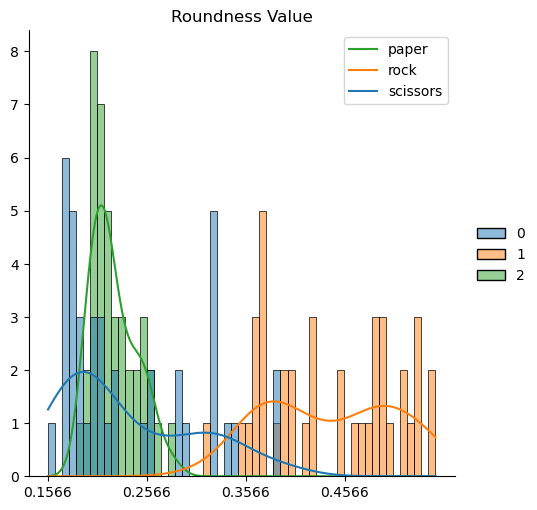

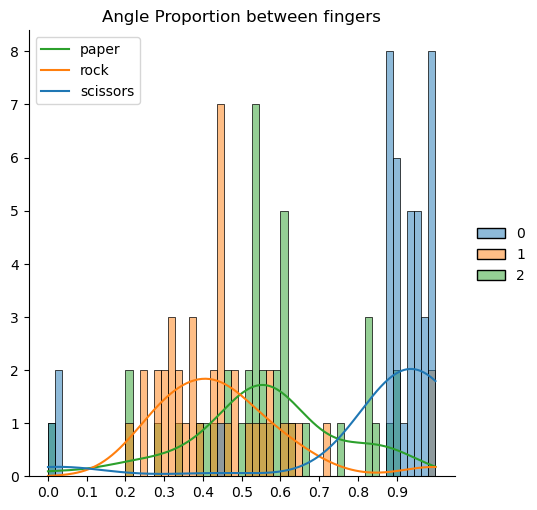

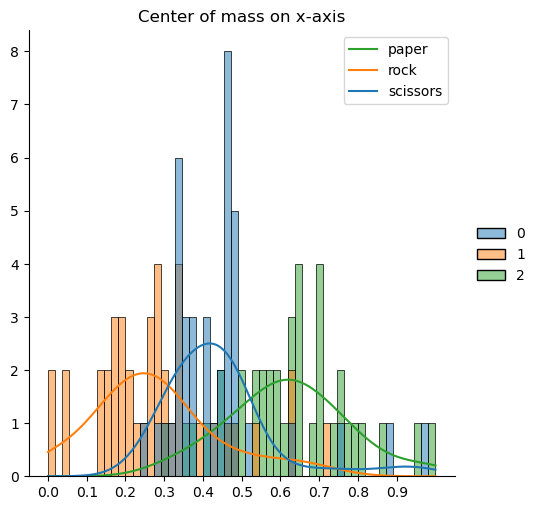

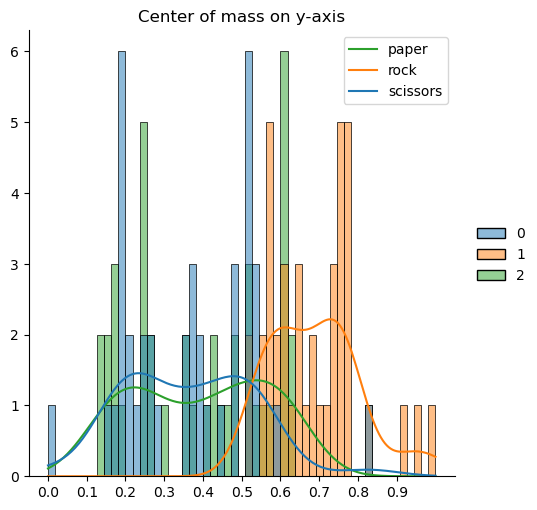

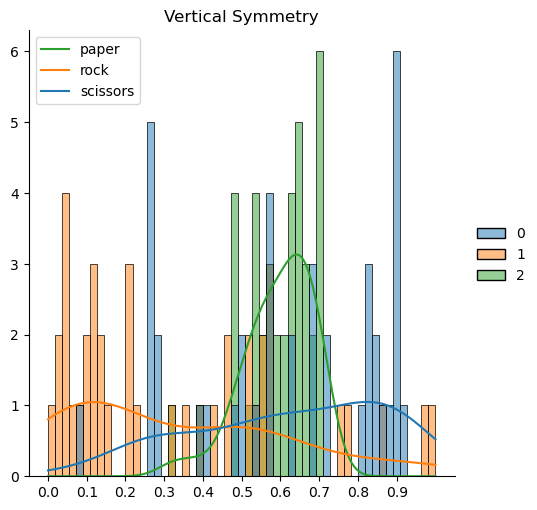

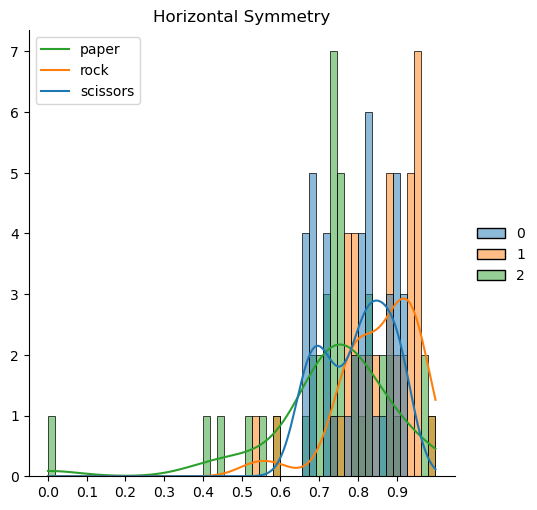

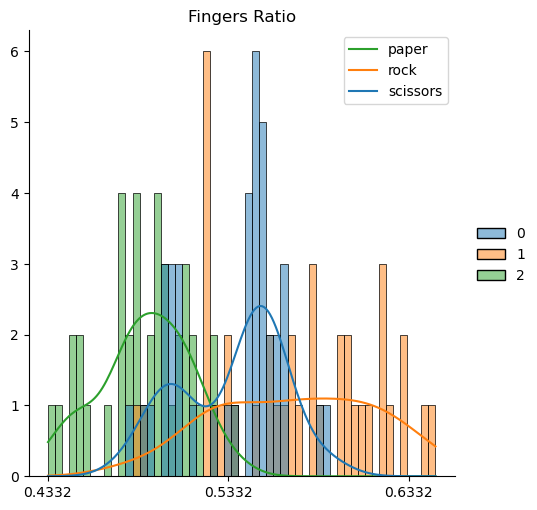

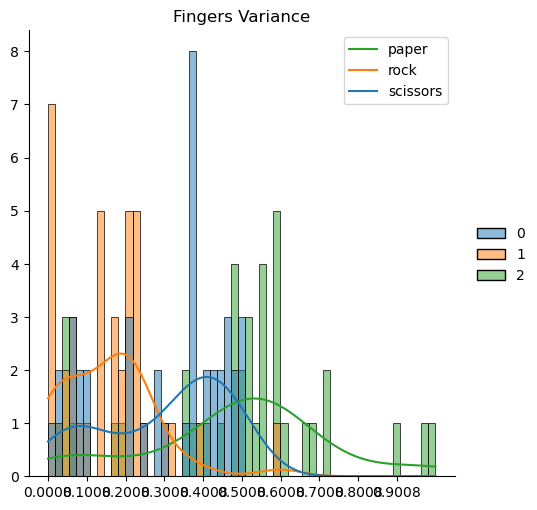

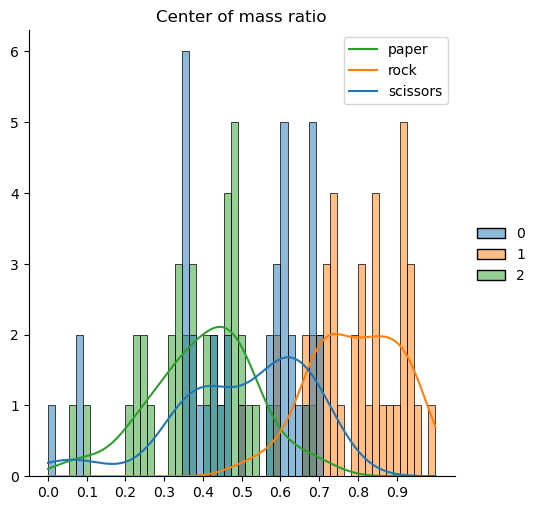

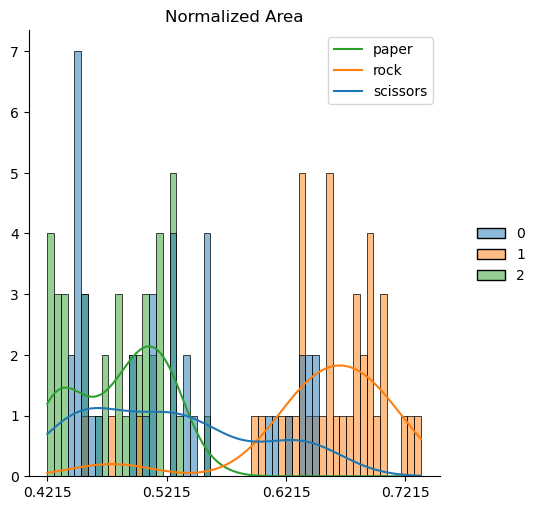

In [125]:
# Histograma de análisis de caracteristicas
for i in range(0, 10):
    data = [x0_train[:,i],x1_train[:,i], x2_train[:,i]]
    s = sns.displot(data, kind='hist', bins=55, kde=True)
    plt.legend(labels=['paper', 'rock', 'scissors'])
    plt.title(titles[i])
    x_axis_min = min(np.concatenate(data))
    x_axis_max = max(np.concatenate(data))
    plt.xticks(np.arange(x_axis_min, x_axis_max, 0.1))
    plt.ylabel('')
    plt.show()

Dado los graficos anteriores podemos analizar que:
1. La redondez de la figura discrimina muy bien entre ...


# 4. Classification

In [127]:
threshold_1 = 0.715 # Center of mass
threshold_2 = 0.3440 # Roundness
threshold_3 = 0.8625 # Angle ratio

def classifier(x):
    center_x_value = x[2]

    if center_x_value <= threshold_1: # Could be a rock or scissor
        roundness_value = x[0]

        if roundness_value <= threshold_2: # could be a scissor (or a paper)
            angle_ratio_value = x[1]
            if angle_ratio_value <= threshold_3:
                return 3 # Is a scissor
            else:
                return 1 # Is a paper
        else: # Is a rock
            return 2

    else: # Could be a scissor or a paper
        angle_ratio_value = x[1]
        if angle_ratio_value <= threshold_3: 
            return 3
        else:
            return 1
    

Y = np.array([classifier(x) for x in X])

Y1_test = Y[40:50]
Y2_test = Y[90:100]
Y3_test = Y[140:150]

Y1_train = Y[0:40]
Y2_train = Y[50:90]
Y3_train = Y[100:140]

# 5. Evaluation

In [128]:

def print_accuracy(accuracy, type):
    print(f'\n{type} Accuracy = {accuracy}%')

def get_accuracy(Y, type):
    true_samples = 0
    false_samples = 0

    for k in range(3):
        true_samples += np.sum(Y[k] == k + 1)
        false_samples += np.sum(Y[k] != k + 1)

    accuracy = true_samples / (true_samples + false_samples) * 100

    print_accuracy(accuracy, type)

    return accuracy


def total_accuracy(acc_test, acc_train):
    return 0.20 * acc_train + 0.8 * acc_test

In [129]:
Y_test = np.array([Y1_test, Y2_test, Y3_test])
Y_train = np.array([Y1_train, Y2_train, Y3_train])

AccTrain = get_accuracy(Y_train, 'Training')
AccTest = get_accuracy(Y_test, 'Testing')
AccTot = total_accuracy(AccTest, AccTrain)
print_accuracy(AccTot, 'Total')



Training Accuracy = 91.66666666666666%

Testing Accuracy = 83.33333333333334%

Total Accuracy = 85.0%
